In [28]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix, classification_report
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

# Original Dataset

In [12]:
# Load the data
df = pd.read_csv('../../data/processed/heart_se.csv')
# Split the data into features and target variable
X = df.drop(['target','index'], axis=1)
y = df['target']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Define the objective function to be optimized
def objective(trial):
    # Suggest values for the hyperparameters
    n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
    leaf_size = trial.suggest_int('leaf_size', 10, 50)
    p = trial.suggest_int('p', 1, 5)
    metric = trial.suggest_categorical('metric', ['minkowski', 'euclidean', 'manhattan', 'chebyshev'])
    
    # Optionally, you can define metric_params if the metric requires additional parameters.
    # For simplicity, we'll set metric_params to None here.
    metric_params = None
    
    # Create a KNN classifier with the suggested hyperparameters
    knn = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        algorithm=algorithm,
        leaf_size=leaf_size,
        p=p,
        metric=metric,
        metric_params=metric_params
    )

    # Use cross-validation to evaluate the model
    score = cross_val_score(knn, X_train, y_train, n_jobs=-1, cv=3)
    accuracy = score.mean()

    return accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Train the final model with the best hyperparameters
knn = KNeighborsClassifier(**best_params)
knn.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = knn.predict(X_test)

# Evaluate the final model
accuracy = knn.score(X_test, y_test)
print(f"Test set accuracy: {accuracy:.2f}")

[I 2024-08-28 22:28:37,909] A new study created in memory with name: no-name-69fb1656-cba3-4a07-8242-24c36d05fa3a
[I 2024-08-28 22:28:37,963] Trial 0 finished with value: 0.8306069958847736 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'algorithm': 'auto', 'leaf_size': 15, 'p': 2, 'metric': 'euclidean'}. Best is trial 0 with value: 0.8306069958847736.
[I 2024-08-28 22:28:37,978] Trial 1 finished with value: 0.8182098765432099 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 37, 'p': 5, 'metric': 'euclidean'}. Best is trial 0 with value: 0.8306069958847736.
[I 2024-08-28 22:28:38,007] Trial 2 finished with value: 0.8181584362139919 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'algorithm': 'auto', 'leaf_size': 33, 'p': 4, 'metric': 'minkowski'}. Best is trial 0 with value: 0.8306069958847736.
[I 2024-08-28 22:28:38,022] Trial 3 finished with value: 0.7642489711934156 and parameters: {'n_neighbors': 2, 'weights': 'un

Best hyperparameters: {'n_neighbors': 11, 'weights': 'distance', 'algorithm': 'brute', 'leaf_size': 30, 'p': 4, 'metric': 'minkowski'}
Test set accuracy: 0.90


In [19]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_slice

# Plot the optimization history
opt_history = plot_optimization_history(study)
opt_history.show()


In [20]:
# Plot the hyperparameter importances
param_importance = plot_param_importances(study)
param_importance.show()

In [21]:

# Plot the parallel coordinate plot to visualize hyperparameter interactions
parallel_coordinate = plot_parallel_coordinate(study)
parallel_coordinate.show()

In [22]:

# Plot the slice plot for each hyperparameter
slice_plot = plot_slice(study)
slice_plot.show()

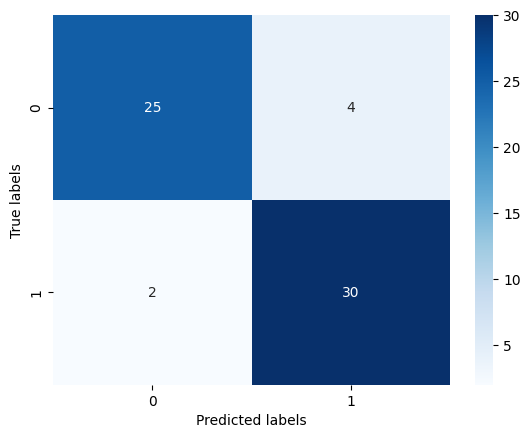

In [29]:
#test the model with the best hyperparameters
y_pred = knn.predict(X_test)

#plot the confusion matrix 
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()



In [30]:
# Generate a classification report
cls_report = classification_report(y_test, y_pred)
print(cls_report)

              precision    recall  f1-score   support

           0       0.93      0.86      0.89        29
           1       0.88      0.94      0.91        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



# Rebalanced

In [ ]:
# Load the data
df_train = pd.read_csv('../../data/processed/resampled/heart_resampled_train_se.csv')
df_test = pd.read_csv('../../data/processed/resampled/heart_resampled_test_se.csv')

# Split the data into features and target variable
X_train = df_train.drop(['target','index'], axis=1)
y_train = df_train['target']
X_test = df_test.drop(['target','index'], axis=1)
y_test = df_test['target']

In [31]:
# Define the objective function to be optimized
def objective(trial):
    # Suggest values for the hyperparameters
    n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
    leaf_size = trial.suggest_int('leaf_size', 10, 50)
    p = trial.suggest_int('p', 1, 5)
    metric = trial.suggest_categorical('metric', ['minkowski', 'euclidean', 'manhattan', 'chebyshev'])
    
    # Optionally, you can define metric_params if the metric requires additional parameters.
    # For simplicity, we'll set metric_params to None here.
    metric_params = None
    
    # Create a KNN classifier with the suggested hyperparameters
    knn = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        algorithm=algorithm,
        leaf_size=leaf_size,
        p=p,
        metric=metric,
        metric_params=metric_params
    )

    # Use cross-validation to evaluate the model
    score = cross_val_score(knn, X_train, y_train, n_jobs=-1, cv=3)
    accuracy = score.mean()

    return accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Train the final model with the best hyperparameters
knn = KNeighborsClassifier(**best_params)
knn.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = knn.predict(X_test)

# Evaluate the final model
accuracy = knn.score(X_test, y_test)
print(f"Test set accuracy: {accuracy:.2f}")

[I 2024-08-28 22:39:45,900] A new study created in memory with name: no-name-c24a6ae8-c10b-4dd4-a2f7-e1988535e2a8
[I 2024-08-28 22:39:47,578] Trial 0 finished with value: 0.8430555555555556 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'algorithm': 'brute', 'leaf_size': 42, 'p': 1, 'metric': 'manhattan'}. Best is trial 0 with value: 0.8430555555555556.
[I 2024-08-28 22:39:47,964] Trial 1 finished with value: 0.8225308641975309 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 25, 'p': 1, 'metric': 'minkowski'}. Best is trial 0 with value: 0.8430555555555556.
[I 2024-08-28 22:39:48,345] Trial 2 finished with value: 0.8264403292181068 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 18, 'p': 5, 'metric': 'euclidean'}. Best is trial 0 with value: 0.8430555555555556.
[I 2024-08-28 22:39:48,362] Trial 3 finished with value: 0.8141460905349794 and parameters: {'n_neighbors': 6, 'weights':

Best hyperparameters: {'n_neighbors': 13, 'weights': 'distance', 'algorithm': 'brute', 'leaf_size': 42, 'p': 1, 'metric': 'manhattan'}
Test set accuracy: 0.90


In [32]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_slice

# Plot the optimization history
opt_history = plot_optimization_history(study)
opt_history.show()


In [33]:
# Plot the hyperparameter importances
param_importance = plot_param_importances(study)
param_importance.show()

In [34]:

# Plot the parallel coordinate plot to visualize hyperparameter interactions
parallel_coordinate = plot_parallel_coordinate(study)
parallel_coordinate.show()

In [35]:

# Plot the slice plot for each hyperparameter
slice_plot = plot_slice(study)
slice_plot.show()

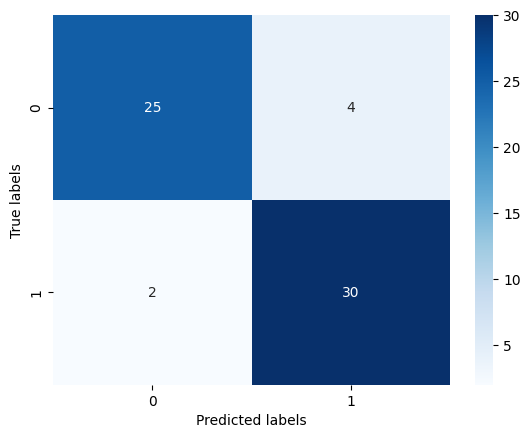

In [36]:
#test the model with the best hyperparameters
y_pred = knn.predict(X_test)

#plot the confusion matrix 
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()



In [37]:
# Generate a classification report
cls_report = classification_report(y_test, y_pred)
print(cls_report)

              precision    recall  f1-score   support

           0       0.93      0.86      0.89        29
           1       0.88      0.94      0.91        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



# Hand Model

In [40]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

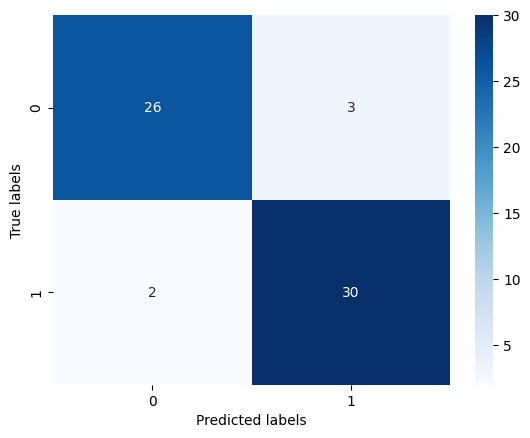

In [41]:
#plot the confusion matrix 
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


In [42]:
# Generate a classification report
cls_report = classification_report(y_test, y_pred)
print(cls_report)

              precision    recall  f1-score   support

           0       0.93      0.90      0.91        29
           1       0.91      0.94      0.92        32

    accuracy                           0.92        61
   macro avg       0.92      0.92      0.92        61
weighted avg       0.92      0.92      0.92        61

